# Прогнозирование оттока клиентов из банка

## Изучение данных

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, plot_confusion_matrix, auc
from sklearn.utils import shuffle
from sklearn.compose import make_column_transformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [198]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [199]:
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [201]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Пропуски в данных

Единственная переменная, в которой содержатся пропуски – это `tenure`. 

In [202]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.000000
Balance,0.000000
NumOfProducts,0.000000


Tenure — сколько лет человек является клиентом банка. Заполним эти пропуски случайным значением в пределах от максимума до минимума в распределении этой переменной.

In [203]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [204]:
df.loc[df['Tenure'].isna(), 'Tenure'] = \
[randint(min(df['Tenure']), max(df['Tenure'])) for i in range(df['Tenure'].isna().sum())]

In [205]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,0.000000
Balance,0.000000
NumOfProducts,0.000000


### Дубликаты

Среди наблюдений нет явных дубликатов.

In [206]:
df.duplicated().sum()

0

### Распределение переменных

Изучим распределение независимых переменных.

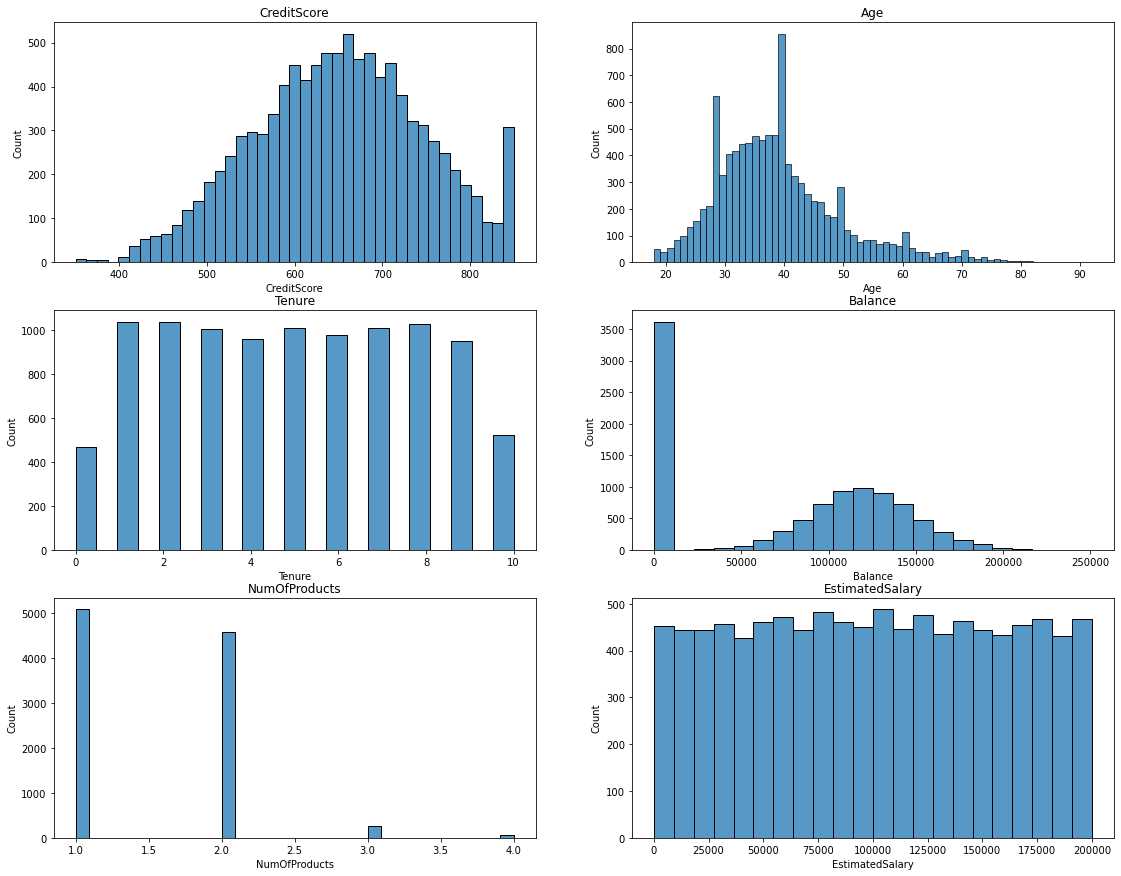

In [207]:
col_names = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
_, axs = plt.subplots(3, 2, figsize=(19,15))
axs = axs.ravel()

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[col_names[i]], data=df)
    ax.tick_params(axis='x')
    ax.set_title(col_names[i])

Видим выброс в переменной `Balance` – баланс на счете. Несмотря на то, что эти данные выделяются на общем фоне, мы не будем их удалять: вполне возможно, что часть людей не пользуются счетом, хотя он у них есть.

In [208]:
df['Balance'].value_counts()

0.00         3617
130170.82       2
105473.74       2
85304.27        1
159397.75       1
             ... 
81556.89        1
112687.69       1
108698.96       1
238387.56       1
130142.79       1
Name: Balance, Length: 6382, dtype: int64

Посмотрим на распределение категориальных переменных: медианное значение крединтного скоринга в группах жензин и мужчин из разных стран.

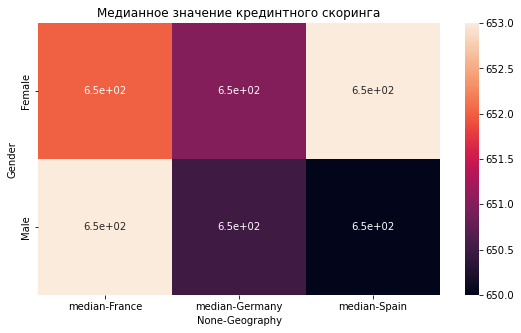

In [209]:
plt.figure(figsize=(9,5))
df_heatmap = df.pivot_table(values='CreditScore', index='Gender',columns='Geography', aggfunc={'median'})
sns.heatmap(df_heatmap,annot=True)
plt.title('Медианное значение крединтного скоринга')
plt.show()

Далее изучим, как распределяется зависимая переменная.

In [210]:
print('Уникальные значения зависимой переменной:', df['Exited'].unique())

Уникальные значения зависимой переменной: [1 0]


Мы наблюдаем дисбаланс в классах.

In [211]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

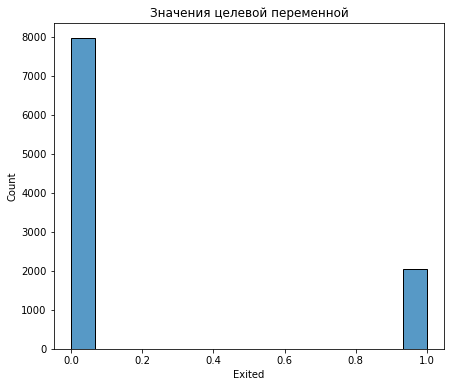

In [212]:
plt.figure(figsize=(7,6))
sns.histplot(x=df['Exited'], data=df)
plt.title('Значения целевой переменной')
plt.show()

Проверяем данные на мультиколлинеарность. Из диаграмм рассеяния видно, что признаки слабо скореллированы. Также можно увидеть тот самый "выброс" в нуле у переменной `Balance`, который мы решили оставить в выборке.

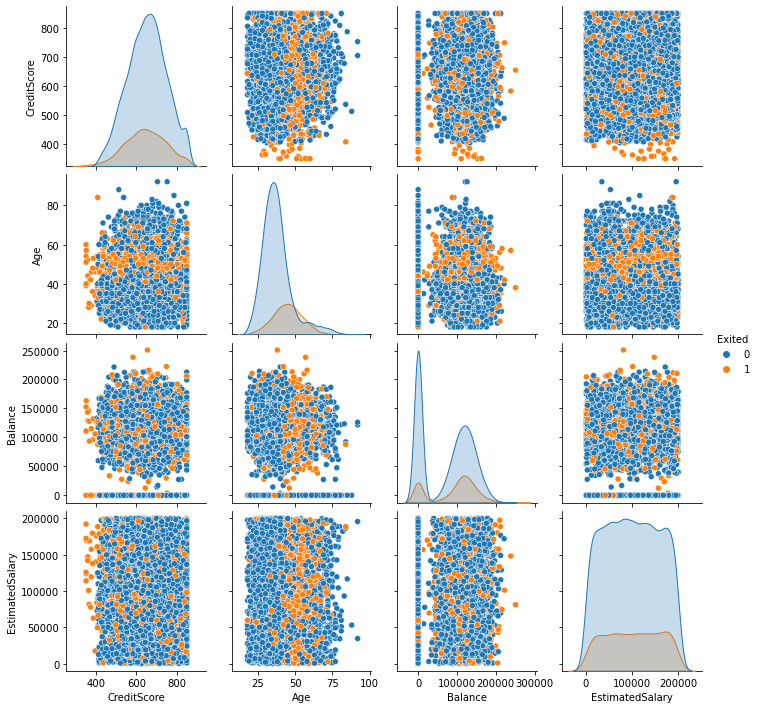

In [213]:
col_names = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']
sns.pairplot(df[col_names], hue='Exited')
plt.show()

**Вывод:** Изучив данные, мы сформулировали следующие задачи:
* Закодировать категориальные переменные (`Gender`, `Geography`)
* Получить тренировачную, валидационную и тестовую выборки
* Масштабировать количественные переменные
* Обучить модели без учета дисбаланса
* Решить проблему дисбаланса классов (выбрать наилучшую стратегию – уменьшение или увеличение классов)
* Обучить модели с учетом дисбаланса, выбрать наилучшую (сравнить метрику F1 с AUR-ROC)
* Провести финальное тестирование

Удалим признаки, которые нам не понадобятся для обучения.

In [214]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Подготовка данных

Используем прямое кодирование (OHE) для категориальных переменных. Избавляемся от первого столбца. 

In [215]:
df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe.head() 

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разбираем выборку на тренировочную, валидационную и тестовую в соотношении 3:1:1.

In [216]:
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=42)

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


Мы будем использовать трансформер в пайплайне для линейной регрессии, чтобы скалировать только числовые переменные.

In [217]:
numerical = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
transformer = make_column_transformer((StandardScaler(), numerical), remainder='passthrough')

## Исследование задачи

Обучим модели без учета дисбаланса классов. Для начала построим модель случайного леса, посчитаем F1 score, выведем график ROC-кривой и посчитаем площадь под ней.

In [218]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(features_train, target_train)

DecisionTreeClassifier(random_state=42)

In [219]:
predictions_valid = model_tree.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_tree.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.4615384615384615
AUC-ROC: 0.6706627680311891


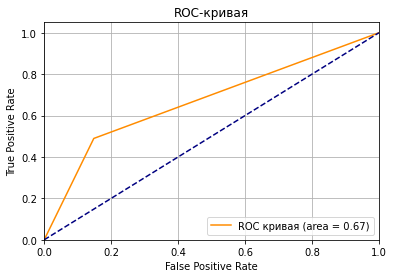

In [220]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Аналогичные шаги проделаем для модели случайного леса и логистической регрессии.

In [221]:
model_forest = RandomForestClassifier(random_state=42)
model_forest.fit(features_train, target_train)

RandomForestClassifier(random_state=42)

In [222]:
predictions_valid = model_forest.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_forest.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.5500000000000002
AUC-ROC: 0.8325178687459389


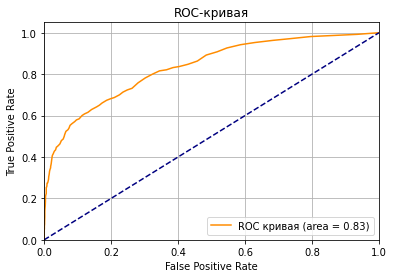

In [223]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Результаты работы логистического классификатора:

In [224]:
model_log = Pipeline([('scaler', transformer),
                      ('linear_clf', LogisticRegression())])
model_log.fit(features_train, target_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression())])

In [225]:
predictions_valid = model_log.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_log.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.29942418426103645
AUC-ROC: 0.7522270955165693


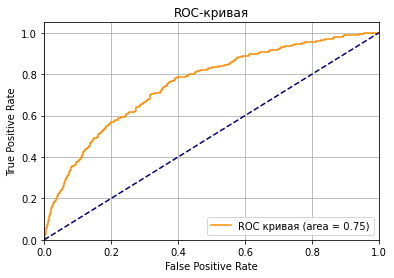

In [226]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Самые низкие показатели качества у логичстического классификатора (F1 = 0.3, AUC-ROC=0.75). Лучше качество мы наблюдаем у модели случайного леса (F1 = 0.56, AUC-ROC=0.83). Высокий показатель F1 score и у модели дерева решений (0.45), но эта модель показывает более низкое качество при её оценке метрикой AUC-ROC (0.66). В целом результаты работы моделей неудовлетворительные. Для решения поставленной задачи необходимо избавиться от дисбаланса в классах.

## Борьба с дисбалансом

В выборке больше всего наблюдений с целевым признаком "0" – больше тех клиентов, кто не ушел из банка. Последовательно сравним стратегии взвешивания классов, уменьшения и увеличения выборки, чтобы сделать выбор в пользу наилучшего подхода.

In [227]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Взвешивание классов

Воспользуемся встроенным методом логистической регрессии и оценим её с учетом баланса классов.

In [228]:
model_tree_weighted = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_tree_weighted.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [229]:
predictions_valid = model_tree_weighted.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_tree_weighted.predict_proba(features_valid.values)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.47532467532467537
AUC-ROC: 0.6769005847953217


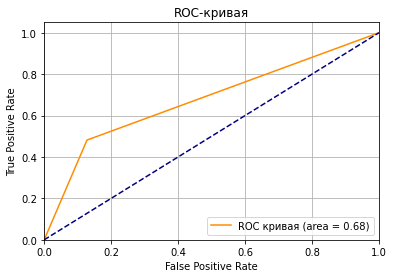

In [230]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [231]:
model_forest_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')
model_forest_weighted.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [232]:
predictions_valid = model_forest_weighted.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_forest_weighted.predict_proba(features_valid.values)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.552542372881356
AUC-ROC: 0.8254686484730344


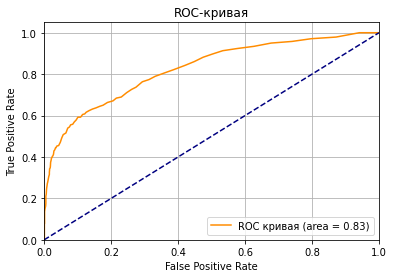

In [233]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Для моделей случайного леса качество на валидационной выборке немного упало. Для дерева решений – не изменилось. Для линейного классификатора качество немного улучшилось: F1 score равно 0.46.

In [234]:
model_log_weighted = Pipeline([('scaler', transformer),
                               ('linear_clf', LogisticRegression(class_weight='balanced'))])

model_log_weighted.fit(features_train, target_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression(class_weight='balanced'))])

In [235]:
predictions_valid = model_log_weighted.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_log_weighted.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.4646288209606987
AUC-ROC: 0.7532179987004548


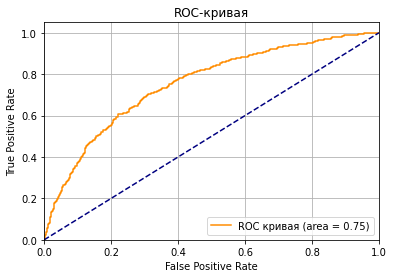

In [236]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Не смотря, что качество модели (F1 score) возрасло с 0.296 до 0.46, размер площали под кривой ROC остался неизменным.

Предлагается рассмотреть иные варианты борьбы с дисбалансом.

### Увеличение выборки 

In [237]:
# заново разбить выборку на трейн и тест

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=42)

Следующий подход – искусственное увеличение выборки. Меньше всего наблюдений в группе тех, кто ушел из банка. Этот класс мы будем искусственно увеличивать.

Попробуем увеличить выборку с помощью Synthetic Minority Oversampling Technique (SMOTE), когда мы генерируем объекты из выборки синтетически, и обучить решающее дерево. Подберем наилучшие параметры для модели, обучим модель, посчитаем метрику F1 score и площадь под кривой AUC-ROC. 

In [253]:
%%time

params = {'tree_clf__max_depth': range(1,13,2),
          'tree_clf__min_samples_leaf': range(1,8),
          'tree_clf__min_samples_split': range(2,10,2)
         }

pipe_tree = Pipeline([('smote', SMOTE(random_state=42)), 
                      ('tree_clf', DecisionTreeClassifier(random_state=42))])

grid_tree = GridSearchCV(pipe_tree, params, cv=KFold(n_splits=5))
grid_tree.fit(features_train, target_train)

CPU times: user 28.7 s, sys: 143 ms, total: 28.9 s
Wall time: 28.9 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [254]:
f1 = np.mean(cross_val_score(grid_tree.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5339646126028944


In [255]:
proba_train = grid_tree.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.8609824926991015


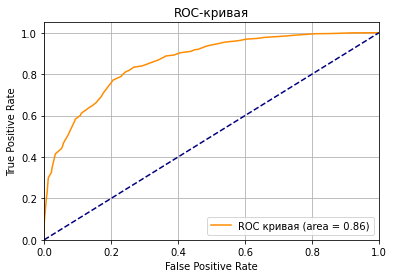

In [256]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Качество дерева решений, оцениваемое по площади под кривой ROC, явно улучшилось.

In [258]:
%%time

pipe_forest = Pipeline([('smote', SMOTE(random_state=42)), 
                        ('forest_clf', RandomForestClassifier(random_state=42))])

params = {'forest_clf__max_depth': range(10, 30, 2),
          'forest_clf__n_estimators': range(30, 60, 5)}

grid_forest = GridSearchCV(pipe_forest, params, cv=KFold(n_splits=5))
grid_forest.fit(features_train, target_train)

CPU times: user 2min 12s, sys: 748 ms, total: 2min 13s
Wall time: 2min 13s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(10, 30, 2),
                         'forest_clf__n_estimators': range(30, 60, 5)})

In [259]:
f1 = np.mean(cross_val_score(grid_forest.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5650074162629182


In [260]:
proba_train = grid_forest.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.9999922308161349


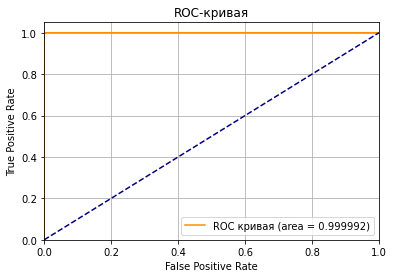

In [263]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Качество случайного после резко возрасло. Рассмотрим линейный классификатор.

In [265]:
%%time

pipe_linear = Pipeline([('smote', SMOTE(random_state=42)),
                        ('scaler', transformer),
                        ('linear_clf', LogisticRegression())])

pipe_linear.fit(features_train, target_train)

CPU times: user 88.5 ms, sys: 30.2 ms, total: 119 ms
Wall time: 42.9 ms


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression())])

In [266]:
f1 = np.mean(cross_val_score(pipe_linear, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.4566711276552532


In [267]:
proba_train = pipe_linear.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.7329751995698434


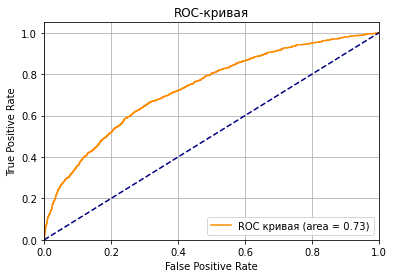

In [268]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Площадь под ROC-кривой и оценка F1 немного (на 0.01) сократились.

**Вывод:**  Оценка дерева решений F1 выросла с 0.47 до 0.53, площадь под ROC-кривой увеличилась с 0.68 до 0.86. Оценка F1 линейного классификатора не изменилась – 0.46, а площадь под ROC-кривой немного сократилась с 0.75 до 0.73. Оценка случайного леса F-score изменилась с 0.55 до 0.57, площадь под ROC-кривой с 0.83 до 0.99[9].

Случайный лес по-прежнему остаётся лучшей моделью для решения поставленной задачи классификации с учетом дисбаланса классов.

### Уменьшение выборки

Альтернативный подход – удаление части наблюдений из наибольшего класса. В нашем случае наибольший класс – те, кто не ушел из банка.

Random Under Sampler уменьшает превалирующий класс, рандомно выбирая сэмплы так, чтобы итоговая пропорция выборок была 1:1 (`sampling_strategy=0.5`).

In [269]:
pipe_tree_down = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)), 
                           ('tree_clf', DecisionTreeClassifier(random_state=42))])

params = {'tree_clf__max_depth': range(1,13,2),
          'tree_clf__min_samples_leaf': range(1,8),
          'tree_clf__min_samples_split': range(2,10,2)
         }

grid_tree_down = GridSearchCV(pipe_tree_down, params, cv=KFold(n_splits=5))
grid_tree_down.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('RUS',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [270]:
f1 = np.mean(cross_val_score(grid_tree_down.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5173138364006159


In [271]:
proba_train = grid_tree_down.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.7953450977559694


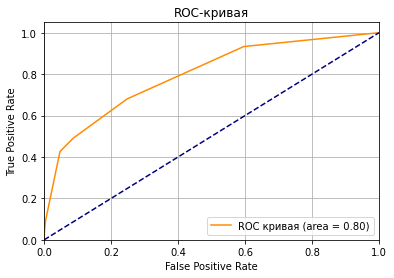

In [272]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Теперь обучим модель случайного леса.

In [273]:
%%time

pipe_forest_down = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)), 
                             ('forest_clf', RandomForestClassifier(random_state=42))])

params = {'forest_clf__max_depth': range(1,13,2),
          'forest_clf__n_estimators': range(10, 30, 10)}

grid_forest_down = GridSearchCV(pipe_forest_down, params, cv=KFold(n_splits=5))
grid_forest_down.fit(features_train, target_train)

CPU times: user 3.14 s, sys: 27.1 ms, total: 3.17 s
Wall time: 3.17 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('RUS',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(1, 13, 2),
                         'forest_clf__n_estimators': range(10, 30, 10)})

In [274]:
f1 = np.mean(cross_val_score(grid_forest_down.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5849749426189657


In [275]:
proba_train = grid_forest_down.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.8605006325481677


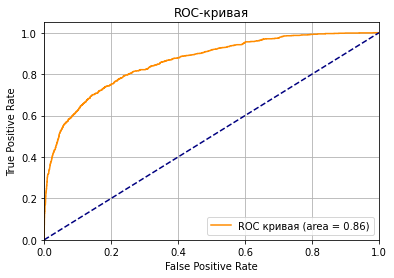

In [276]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Теперь рассмотрим линейный классификатор.

In [278]:
%%time

pipe_linear = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                        ('scaler', transformer),
                        ('linear_clf', LogisticRegression())])

pipe_linear.fit(features_train, target_train)

CPU times: user 62.3 ms, sys: 20.7 ms, total: 83 ms
Wall time: 29 ms


Pipeline(steps=[('RUS',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression())])

In [279]:
f1 = np.mean(cross_val_score(pipe_linear, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.46426406431992967


In [280]:
proba_train = pipe_linear.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.7694951447723382


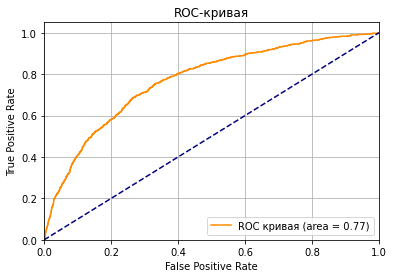

In [281]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** Качество линейной регрессии и случайного леса выше при уменьшении выборки, чем при её увеличении. Качество дерева решений упало. Случайный лес – по-прежнему лучшая модель, оценка F1 – 0.58, площадт под ROC кривой – 0.86.

### Комбинация двух стратегий

На данном этапе лучше всего с задачей классификации и с учетом дисбаланса классов справляется модель случайного леса. Мы попробовали две стратегии для борьбы с дисбаланском – upsampling и downsampling, попробовали реализовать их как вручную, так и с помощью встроенных библиотек. В некоторых [статьях](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) предлагалось комбинировать upsampling и downsampling, то есть увеличивать недостающий класс и паралельно уменьшать тот класс, которого в избытке. Попробуем реализовать этот подход.

In [282]:
over = SMOTE(random_state=42)
under = RandomUnderSampler(random_state=42)
clf = RandomForestClassifier(random_state=42)
steps = [('over', over), ('under', under), ('forest_clf', clf)]
pipeline_combo = Pipeline(steps=steps)

In [283]:
params = {'forest_clf__max_depth': range(10,30,2),
          'forest_clf__n_estimators': range(30, 60, 5)}

grid_forest_combo = GridSearchCV(pipeline_combo, params, cv=KFold(n_splits=5))

grid_forest_combo.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('under',
                                        RandomUnderSampler(random_state=42)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(10, 30, 2),
                         'forest_clf__n_estimators': range(30, 60, 5)})

In [284]:
f1 = np.mean(cross_val_score(grid_forest_combo.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5649252703277818


In [285]:
proba_train = grid_forest_combo.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.99999863398965


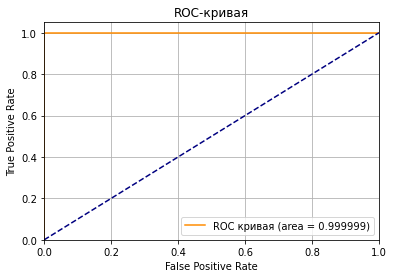

In [287]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Вывод:** качество метрики F1 ухудшилось после комбинирования двух подходов. 

Поскольку техника уменьшения выборки показала самый высокий результат, предлагается испольковать её.

## Тестирование модели

In [300]:
predictions_test = grid_forest_down.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_forest_down.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.5882352941176471
AUC-ROC: 0.8423152985796664


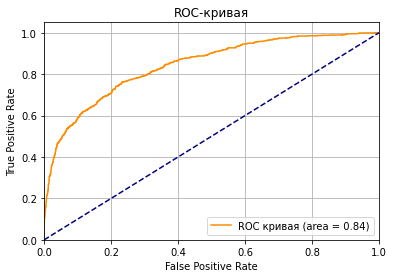

In [301]:
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Выводы:** Самые высокие показатели оценки F1 на тесте показал случайный лес. Предлагается использовать данную модель для решения поставленной задачи. Также предлагается испоьзовать технику балансировки классов "уменьшение выборки". Благодаря этому можно получить высокую оценку качества ROC-AUC (0.84) и высокий показатель F1, равный 0.59.

## Вывод

Мы построили предсказательную модель, которая определяет, уйдет ли клиент из банка или нет. Самая лучшая оценка на тестовой и валидационной выборе у случайного леса, поэтому предлагается использовать эту модель в работе. В исследовании мы последовательно изучили и подготовили данные. Определив, что в выборке есть дисбаланс классов, решили эту проблему, отдав предпочтение стратегии уменьшения выборки. В результате мы достигли значение F score = 0.59 на тестовой выборке. Площадь под кривой ROC составила 0.84, что также свидетельствует о хорошей прдесказательной способности модели. 